# Participant Prediction

In [1]:
%precision 3
%matplotlib inline

In [2]:
# Year to predict for
PREDICTION_YEAR = 2016

# Year to train prediction for
TRAINING_PREDICTION_YEAR = PREDICTION_YEAR - 1

# Percent of dataset to use for training
TRAINING_DATA_PERCENT = 0.70

# Available year range
MIN_YEAR = 2003
MAX_YEAR = 2016

## Preprocessing

In [3]:
import data
import pandas as pd

In [4]:
def get_recurring_runners_from(df, curr_year, target_year):
    return df.loc[(df.year == target_year) & (df.years_since_run == target_year - curr_year)]


def set_participated_in_year(df, curr_year, target_year):
    next_df = get_recurring_runners_from(df, curr_year, target_year)
    recurring_ids = next_df.id.unique()
    df.loc[(df.year == curr_year) & (df.id.isin(recurring_ids)), "participated_in_year"] = True
    
    
def set_all_participated_in_year(df, target_year):
    df["participated_in_year"] = False
    for year in range(MIN_YEAR, target_year):
        set_participated_in_year(df, year, target_year)


def set_run_count_class(run_count):
    if run_count <= 0:
        return 0
    elif run_count < 2:
        return 1
    elif run_count < 3:
        return 2
    elif run_count < 5:
        return 3
    elif run_count < 7:
        return 4
    else:
        return 5

In [5]:
raw_df = data.get_data()
df = pd.DataFrame()

df["id"] = raw_df["id"]
df["age"] = raw_df["age"].apply(lambda x: 5 * (x // 5))
df["male"] = raw_df["male"]
df["year"] = raw_df["year"]
df["run_count"] = raw_df["run_count"]
df["run_count_class"] = raw_df["run_count"].apply(set_run_count_class)
df["ran_a_lot"] = raw_df["run_count"].apply(lambda x: x > 7)
df["years_since_run"] = raw_df["years_since_run"].apply(lambda x: max(0, x))
df["ran_last_year"] = raw_df["years_since_run"].apply(lambda x: x == 1)
df["years_to_prediction"] = raw_df["year"].apply(lambda x: TRAINING_PREDICTION_YEAR - x)
df["time_in_seconds"] = raw_df["time_in_seconds"]
df["ignore"] = raw_df["ignore"]
set_all_participated_in_year(df, TRAINING_PREDICTION_YEAR)

all_df = df.copy()    

df = df.loc[df.ignore == False]
df = df.sample(frac=1)

In [6]:
df

,id,age,male,year,run_count,run_count_class,ran_a_lot,years_since_run,ran_last_year,years_to_prediction,time_in_seconds,ignore,participated_in_year
34197,25970,40,1,2013,0,0,False,0,False,2,15405.0,False,False
32337,24204,25,1,2013,0,0,False,0,False,2,13543.0,False,False
33112,24938,50,1,2013,0,0,False,0,False,2,13091.0,False,False
30961,22910,45,1,2012,0,0,False,0,False,3,15283.0,False,False
3995,2454,40,0,2016,0,0,False,0,False,-1,15875.0,False,False
19804,13552,35,0,2009,0,0,False,0,False,6,16484.0,False,False
21623,14965,55,1,2015,2,2,False,3,False,0,20832.0,False,False
37843,29457,35,1,2015,0,0,False,0,False,0,16996.0,False,False
7320,4210,60,1,2005,1,1,False,2,False,10,17609.0,False,False
19934,13660,45,1,2014,1,1,False,5,False,1,21736.0,False,False


## Splitting data

In [7]:
import numpy as np

In [8]:
def get_nb_inputs(df):
    return df[["age", "male", "run_count", "years_since_run", "years_to_prediction"]]


def get_reg_inputs(df):
    return df[["age", "male", "run_count", "years_since_run", "time_in_seconds"]]


def get_outputs(df):
    return df["participated_in_year"]


def count(df):
    return df.count().id

In [9]:
dataset = df[df.year < TRAINING_PREDICTION_YEAR]
training_mask = np.random.rand(len(dataset)) < TRAINING_DATA_PERCENT
training = dataset[training_mask]
testing = dataset[~training_mask]

training_nb_inputs = get_nb_inputs(training)
training_reg_inputs = get_reg_inputs(training)
training_outputs = get_outputs(training)

testing_nb_inputs = get_nb_inputs(testing)
testing_reg_inputs = get_reg_inputs(testing)
testing_outputs = get_outputs(testing)

In [10]:
training_positives = count(training[training.participated_in_year])
training_total = count(training)

testing_positives = count(testing[testing.participated_in_year])
testing_total = count(testing)

In [11]:
training_positives, training_total, training_positives / training_total

(484, 23017, 0.021)

In [12]:
testing_positives, testing_total, testing_positives / testing_total

(225, 9634, 0.023)

## Training

#### Bernoulli Naive Bayes

In [13]:
from sklearn.naive_bayes import BernoulliNB

In [14]:
bnb = BernoulliNB()
bnb = bnb.fit(training_nb_inputs, training_outputs)

In [15]:
bnb_predictions = bnb.predict(testing_nb_inputs)

#### Gaussian Naive Bayes

In [16]:
from sklearn.naive_bayes import GaussianNB

In [17]:
gnb = GaussianNB()
gnb = gnb.fit(training_nb_inputs, training_outputs)

In [18]:
gnb_predictions = gnb.predict(testing_nb_inputs)

#### Multinomial Naive Bayes

In [19]:
from sklearn.naive_bayes import MultinomialNB

In [20]:
mnb = MultinomialNB()
mnb = mnb.fit(training_nb_inputs, training_outputs)

In [21]:
mnb_predictions = mnb.predict(testing_nb_inputs)

#### Custom Multinomial Naive Bayes

In [22]:
from naive_bayes import MultinomialNaiveBayes

In [23]:
custom_mnb = MultinomialNaiveBayes()
custom_mnb.fit(training_nb_inputs.as_matrix(), training_outputs.as_matrix())

In [24]:
custom_mnb_predictions = custom_mnb.predict(testing_nb_inputs.as_matrix())

#### Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression

In [26]:
reg = LogisticRegression()
reg = reg.fit(training_reg_inputs, training_outputs)

In [27]:
reg_predictions = reg.predict(testing_reg_inputs)

## Testing

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [29]:
def get_confusion_matrix(predictions, truth):
    confusion = confusion_matrix(truth, predictions)
    confusion_df = pd.DataFrame(confusion,
                                index=["N", "Y"],
                                columns=["N", "Y"])

    percent_df = confusion_df.applymap(lambda x: x / confusion.sum())

    return confusion_df, percent_df


def plot_confusion_matrix(confusion, percent):
    fig, axs = plt.subplots(nrows=2, sharex=True)
    sns.heatmap(confusion, annot=True, fmt="d", ax=axs[0])
    sns.heatmap(percent, annot=True, ax=axs[1])

#### Expected Distribution

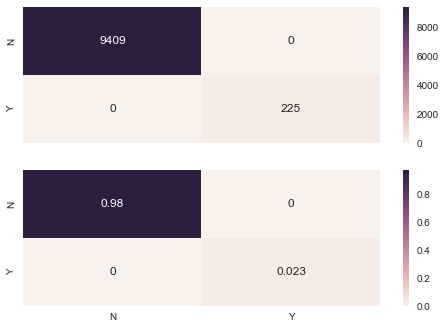

In [30]:
plot_confusion_matrix(*get_confusion_matrix(testing_outputs, testing_outputs))

#### Bernouilli Naive Bayes

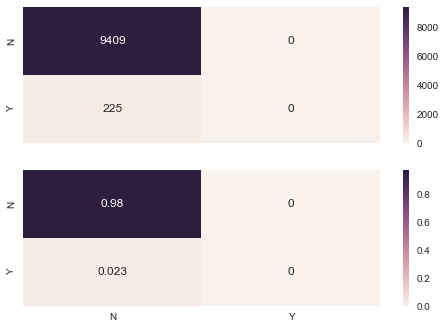

In [31]:
plot_confusion_matrix(*get_confusion_matrix(bnb_predictions, testing_outputs))

In [32]:
bnb.score(testing_nb_inputs, testing_outputs)

0.977

#### Gaussian Naive Bayes

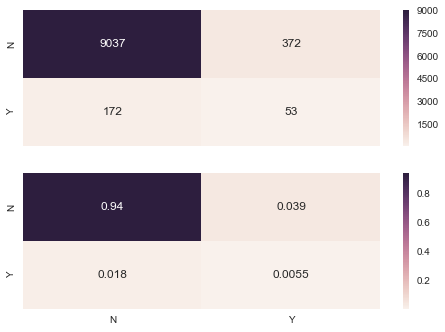

In [33]:
plot_confusion_matrix(*get_confusion_matrix(gnb_predictions, testing_outputs))

In [34]:
gnb.score(testing_nb_inputs, testing_outputs)

0.944

#### Multinomial Naive Bayes

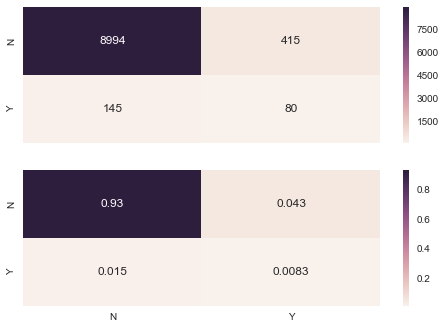

In [35]:
plot_confusion_matrix(*get_confusion_matrix(mnb_predictions, testing_outputs))

In [36]:
mnb.score(testing_nb_inputs, testing_outputs)

0.942

#### Custom Multinomial Naive Bayes

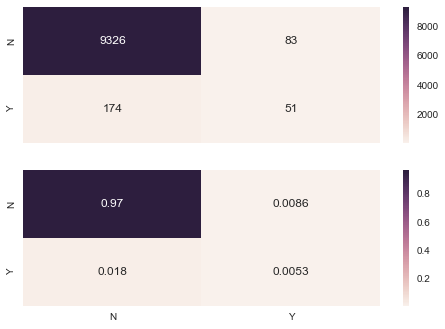

In [37]:
plot_confusion_matrix(*get_confusion_matrix(custom_mnb_predictions, testing_outputs))

In [38]:
custom_mnb.score(testing_nb_inputs.as_matrix(), testing_outputs.as_matrix())

0.973

#### Logistic Regression

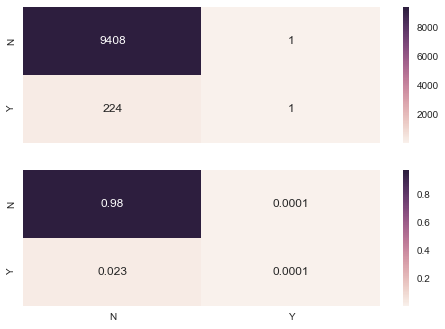

In [39]:
plot_confusion_matrix(*get_confusion_matrix(reg_predictions, testing_outputs))

In [40]:
reg.score(testing_reg_inputs, testing_outputs)

0.977

## Future Prediction

In [41]:
prediction_df = all_df.copy().sort_values(by=["id", "year"])
prediction_df["years_to_prediction"] = all_df["year"].apply(lambda x: PREDICTION_YEAR - x)

set_all_participated_in_year(prediction_df, PREDICTION_YEAR)

prediction_df = prediction_df[prediction_df.year < PREDICTION_YEAR]
prediction_df.drop_duplicates(keep="last", subset="id", inplace=True)

In [42]:
prediction_nb_inputs = get_nb_inputs(prediction_df)
prediction_reg_inputs = get_reg_inputs(prediction_df)

prediction_outputs = get_outputs(prediction_df)

In [43]:
bnb_predictions = bnb.predict(prediction_nb_inputs)
gnb_predictions = gnb.predict(prediction_nb_inputs)
mnb_predictions = mnb.predict(prediction_nb_inputs)
custom_mnb_predictions = custom_mnb.predict(prediction_nb_inputs.as_matrix())
reg_predictions = reg.predict(prediction_reg_inputs)

In [44]:
total = count(prediction_df)
[
    sum(bnb_predictions) / total,
    sum(gnb_predictions) / total,
    sum(mnb_predictions) / total,
    sum(custom_mnb_predictions) / total,
    sum(reg_predictions) / total    
]

[0.000, 0.036, 0.045, 0.008, 0.000]

### Metrics

*Ignore score if no data is available for the prediction year.*

#### Expected Distribution

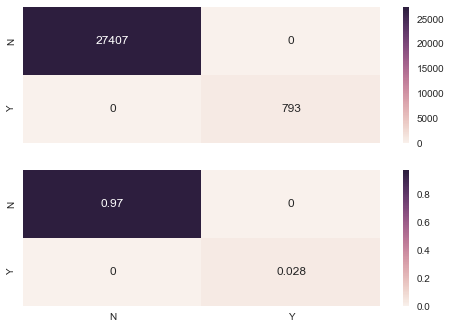

In [45]:
if PREDICTION_YEAR <= MAX_YEAR:
    plot_confusion_matrix(*get_confusion_matrix(prediction_outputs, prediction_outputs))

#### Bernouilli Naive Bayes

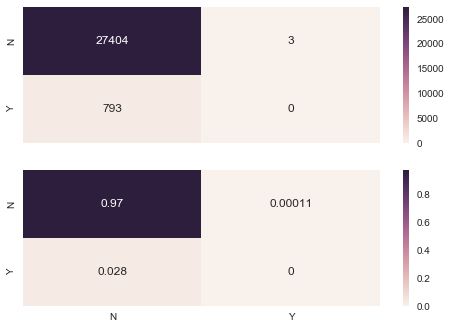

In [46]:
plot_confusion_matrix(*get_confusion_matrix(bnb_predictions, prediction_outputs))

In [47]:
bnb.score(prediction_nb_inputs, prediction_outputs)

0.972

#### Gaussian Naive Bayes

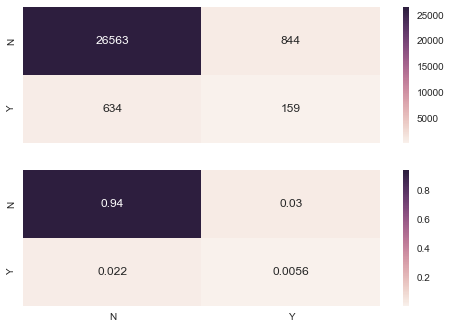

In [48]:
plot_confusion_matrix(*get_confusion_matrix(gnb_predictions, prediction_outputs))

In [49]:
gnb.score(prediction_nb_inputs, prediction_outputs)

0.948

#### Multinomial Naive Bayes

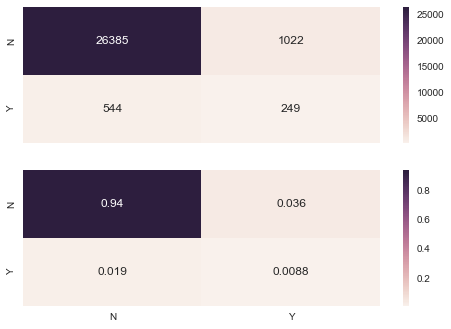

In [50]:
plot_confusion_matrix(*get_confusion_matrix(mnb_predictions, prediction_outputs))

In [51]:
mnb.score(prediction_nb_inputs, prediction_outputs)

0.944

#### Custom Multinomial Naive Bayes

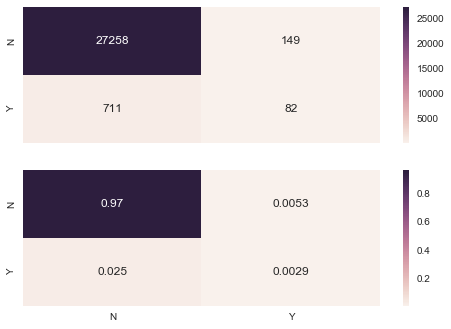

In [52]:
plot_confusion_matrix(*get_confusion_matrix(custom_mnb_predictions, prediction_outputs))

In [53]:
custom_mnb.score(prediction_nb_inputs.as_matrix(), prediction_outputs.as_matrix())

0.970

#### Logistic Regression

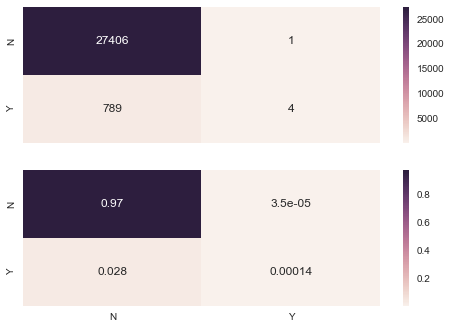

In [54]:
plot_confusion_matrix(*get_confusion_matrix(reg_predictions, prediction_outputs))

In [55]:
reg.score(prediction_reg_inputs, prediction_outputs)

0.972